Processing RN
  l0=1
  l0=2
  l0=3
  l0=4
  l0=5
  l0=6
Processing BAN
  l0=1
  l0=2
  l0=3
  l0=4
  l0=5
  l0=6
Processing TLN
  l0=1
  l0=2
  l0=3
  l0=4
  l0=5
  l0=6
Processing SLN
  l0=1
  l0=2
  l0=3
  l0=4
  l0=5
  l0=6
Processing HLN
  l0=1
  l0=2
  l0=3
  l0=4
  l0=5
  l0=6


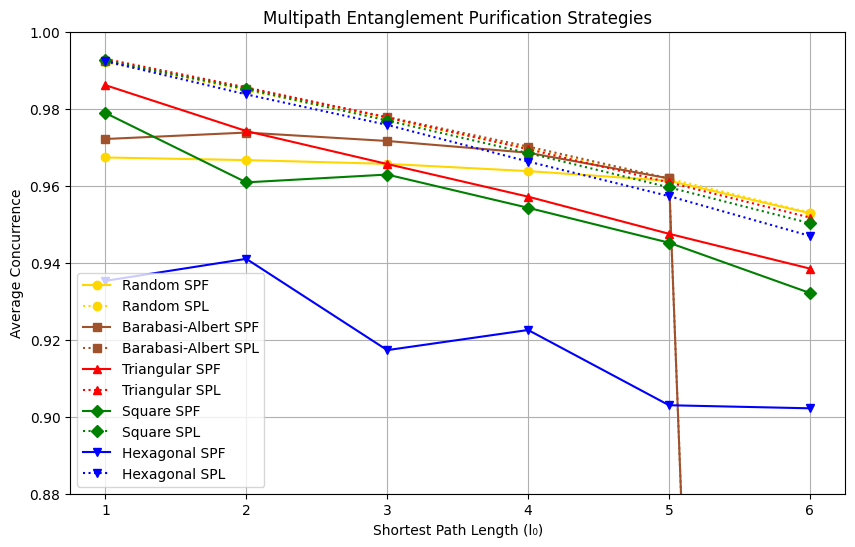

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
num_nodes = 10000
num_edges = 50000
delta = 0.02  # 1 - mean(c_e) = 0.02
topologies = ['RN', 'BAN', 'TLN', 'SLN', 'HLN']
k_map = {'RN': 3, 'BAN': 3, 'TLN': 3, 'SLN': 3, 'HLN': 3}
l0_values = range(1, 7)
num_samples = 10000

def generate_network(topology, num_nodes, num_edges):
    np.random.seed(42)
    G = nx.Graph()
    pos = {}
    if topology == 'RN':
        p = 2 * num_edges / (num_nodes * (num_nodes - 1))
        G = nx.erdos_renyi_graph(num_nodes, p)
    elif topology == 'BAN':
        m = num_edges // num_nodes
        G = nx.barabasi_albert_graph(num_nodes, m)
    elif topology == 'SLN':
        size = int(np.sqrt(num_nodes))
        G = nx.grid_2d_graph(size, size)
        mapping = {node: i for i, node in enumerate(G.nodes())}
        pos = {i: (x, y) for (x, y), i in mapping.items()}
        G = nx.relabel_nodes(G, mapping)
        nx.set_node_attributes(G, pos, 'pos')
    elif topology == 'TLN':
        m = int((2 * num_nodes)**0.5)
        G = nx.triangular_lattice_graph(m, m)
        pos = nx.get_node_attributes(G, 'pos')
        mapping = {node: i for i, node in enumerate(G.nodes())}
        G = nx.relabel_nodes(G, mapping)
        pos = {mapping[node]: p for node, p in pos.items()}
        nx.set_node_attributes(G, pos, 'pos')
    elif topology == 'HLN':
        m = int((num_nodes / 2)**0.5)
        G = nx.hexagonal_lattice_graph(m, m)
        pos = nx.get_node_attributes(G, 'pos')
        mapping = {node: i for i, node in enumerate(G.nodes())}
        G = nx.relabel_nodes(G, mapping)
        pos = {mapping[node]: p for node, p in pos.items()}
        nx.set_node_attributes(G, pos, 'pos')
    else:
        raise ValueError("Unsupported topology.")
    for u, v in G.edges():
        G[u][v]['c_e'] = np.random.uniform(0.97, 0.99)
    return G

def find_paths(G, topology, s, d, max_k):
    if topology in ['TLN', 'SLN', 'HLN']:
        pos_s = G.nodes[s]['pos']
        pos_d = G.nodes[d]['pos']
        dx = abs(pos_d[0] - pos_s[0])
        dy = abs(pos_d[1] - pos_s[1])
        try:
            l0 = nx.shortest_path_length(G, s, d)
        except nx.NetworkXNoPath:
            return []
        path_lengths = []
        
        if topology == 'TLN':
            if l0 == 1:
                # Nearest Neighbours
                path_lengths = [1, 2, 2, 4, 4, 7]
            else:
                # Calculate Euclidean distance
                distance = math.hypot(dx, dy)
                
                # Check linear case (integer distance)
                if abs(distance - round(distance)) < 1e-9:
                    # Linear
                    if l0 == 2:
                        path_lengths = [2, 3, 3, 6, 6, 10]
                    else:  # l0 > 2
                        path_lengths = [l0, l0+1, l0+1, l0+4, l0+4, l0+7]
                else:
                    # Check diagonal case (multiple of sqrt(3))
                    multiple = distance / math.sqrt(3)
                    if abs(multiple - round(multiple)) < 1e-9:
                        # Diagonal
                        path_lengths = [l0, l0, l0+2, l0+2, l0+4, l0+4]
                    else:
                        # Non-symmetric Diagonal
                        path_lengths = [l0, l0, l0+2, l0+2, l0+5, l0+5]
                # Truncate to max_k elements
                path_lengths = path_lengths[:max_k]
        
        elif topology == 'SLN':
            if dx == dy:
                # Diagonal
                path_lengths = [l0, l0, l0+4, l0+4]
            else:
                # Non-diagonal
                path_lengths = [l0, l0+2, l0+2, l0+8]
            # Truncate to max_k elements
            path_lengths = path_lengths[:max_k]
        
        elif topology == 'HLN':
           # Determine Type I or Type II based on coordinate parity
            # Calculate sum of coordinates for source and destination
            sum_s = pos_s[0] + pos_s[1]
            sum_d = pos_d[0] + pos_d[1]
            # Check if they have the same parity (even/odd)
            if (sum_s % 2) == (sum_d % 2):
                # Type I nodes (same parity)
                path_lengths = [l0, l0+4, l0+4]
            else:
                # Type II nodes (different parity)
                if l0 % 2 == 0:
                    path_lengths = [l0, l0+2, l0+6]
                else:
                    path_lengths = [l0, l0, l0+8]
            # Truncate to max_k elements
            path_lengths = path_lengths[:max_k]
        
    else:
        path_lengths = []
        try:
            paths = nx.shortest_simple_paths(G, s, d)
            for i, path in enumerate(paths):
                if i >= max_k:
                    break
                path_lengths.append(len(path) - 1)
        except nx.NetworkXNoPath:
            pass
    return path_lengths[:max_k]

def calculate_C(l0, l1, l2, delta):
    numerator = (1 
                 - (1/6) * (3 * l0 + 3 * l1 + 4 * l2) * delta 
                 + (1/18) * (4 * l0 * l1 + 5 * l1 * l2 + 5 * l2 * l0) * delta**2 
                 - (7/54) * l0 * l1 * l2 * delta**3)
    
    denominator = (1 
                   - (1/6) * (3 * l0 + 3 * l1 + 2 * l2) * delta 
                   + (1/18) * (6 * l0 * l1 + 4 * l1 * l2 + 4 * l2 * l0) * delta**2 
                   - (4/27) * l0 * l1 * l2 * delta**3)
    
    if denominator == 0:
        return 0.0  # Avoid division by zero
    
    return numerator / denominator

# Simulation
results = {topo: {l0: {'SPF': 0.0, 'SPL': 0.0} for l0 in l0_values} for topo in topologies}

for topology in topologies:
    print(f"Processing {topology}")
    G = generate_network(topology, num_nodes, num_edges)
    max_k = k_map[topology]
    for l0 in l0_values:
        print(f"  l0={l0}")
        total_spf, total_spl, count = 0.0, 0.0, 0
        # Sample S-D pairs
        for _ in range(num_samples):
            s = np.random.choice(G.nodes())
            d = np.random.choice(G.nodes())
            if s == d:
                continue
            try:
                spl = nx.shortest_path_length(G, s, d)
            except nx.NetworkXNoPath:
                continue
            if spl != l0:
                continue
            # Find paths
            path_lengths = find_paths(G, topology, s, d, max_k)
            if len(path_lengths) < 3:
                continue
            # Take first three paths
            l0_p, l1_p, l2_p = path_lengths[0], path_lengths[1], path_lengths[2]
            # Calculate concurrence for SPF and SPL
            try:
                C_spf = calculate_C(l0_p, l1_p, l2_p, delta)
                C_spl = calculate_C(l2_p, l1_p, l0_p, delta)
            except:
                C_spf, C_spl = 0.0, 0.0
            total_spf += C_spf
            total_spl += C_spl
            count += 1
        # Average
        if count > 0:
            avg_spf = total_spf / count
            avg_spl = total_spl / count
        else:
            avg_spf, avg_spl = 0.0, 0.0
        results[topology][l0]['SPF'] = avg_spf
        results[topology][l0]['SPL'] = avg_spl

# Plotting
plt.figure(figsize=(10, 6))
markers = ['o', 's', '^', 'D', 'v']
colors = ['gold', 'sienna', 'red', 'green', 'blue']
labels = ['Random', 'Barabasi-Albert', 'Triangular', 'Square', 'Hexagonal']

for idx, topo in enumerate(topologies):
    x = list(l0_values)
    y_spf = [results[topo][l0]['SPF'] for l0 in l0_values]
    y_spl = [results[topo][l0]['SPL'] for l0 in l0_values]
    plt.plot(x, y_spf, marker=markers[idx], color=colors[idx], linestyle='-', label=f'{labels[idx]} SPF')
    plt.plot(x, y_spl, marker=markers[idx], color=colors[idx], linestyle=':', label=f'{labels[idx]} SPL')

plt.xlabel('Shortest Path Length (l₀)')
plt.ylabel('Average Concurrence')
plt.title('Multipath Entanglement Purification Strategies')
plt.legend()
plt.grid(True)
plt.ylim(0.88, 1.00)
plt.show()